# Breast Cancer Prediction

## About Dataset

Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes:
  - normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

## Approach

AttentionUNet/UNet is the best know model for Multi-Class Segmentation, thats why we will be creating a Attention UNet Model.
As the image Dataset is old, please do not use it for any new medical operations.
All the images are of 500 X 500 pixels, Kaggle RAM wil not be enough so we will be resizing the Image to 256 X 256 pixels.
Model Architecture

**TOOD: The Model will consist of a Encoder Block, Decoder Block and a Attention Gate.**


## Dataset: 
https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset



In [1]:
!pip install scikit-image
!pip install scikit-learn
!pip install seaborn
!pip install pillow
!pip install Image

In [2]:
# Import required packages

## common packages
import os
import numpy as np
import pandas as pd
from glob import glob

## Data
from keras.preprocessing.image import load_img, img_to_array

## Data Vizualisation
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.image as tfi
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
import cv2

# Model
from sklearn.model_selection import train_test_split
import seaborn as sns


2025-01-21 11:17:25.880154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 11:17:25.961834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)    
    plt.axis('off')



In [4]:
# Extract labels from filenames
def get_labels_from_filenames(image_paths):
    labels = []
    for path in image_paths:
        if "benign" in path.lower():
            labels.append(0)  # Benign -> 0
        elif "malignant" in path.lower():
            labels.append(1)  # Malignant -> 1
        else:
            raise ValueError(f"Unknown class in filename: {path}")
    return labels

In [13]:
# filter images based on the Benign_malignant csv-file, as it contains the images allowed for using, e.g. not having markers inside the image
# such as: size of the tumor. While markers such as 'Left Breast', 'RT' are allowed.

In [4]:
df_allowed_image_index_for_processing = pd.read_csv('./data/Benign_malignant_indices.csv')

# Generate benign and malignant paths
benign_paths = [
    f'./data/Breast_Tumor_Dataset/Dataset_BUSI_with_GT/benign/benign ({num}).png'
    for num in df_allowed_image_index_for_processing['benign']
]

malignant_paths = [
    f'./data/Breast_Tumor_Dataset/Dataset_BUSI_with_GT/malignant/malignant ({num}).png'
    for num in df_allowed_image_index_for_processing['malignant']
]

# Generate corresponding mask paths for benign and malignant images
benign_mask_paths = [
    f'./data/Breast_Tumor_Dataset/Dataset_BUSI_with_GT/benign/benign ({num})_mask.png'
    for num in df_allowed_image_index_for_processing['benign']
]

malignant_mask_paths = [
    f'./data/Breast_Tumor_Dataset/Dataset_BUSI_with_GT/malignant/malignant ({num})_mask.png'
    for num in df_allowed_image_index_for_processing['malignant']
]

In [17]:
def load_image(image, SIZE):    
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, size, mask=False):
    images = np.zeros((len(image_paths), size, size, 3))  # Include 3 channels for RGB

    for i, image_path in enumerate(image_paths):        
        img = load_image(image_path, size)
        if img is None and mask:
            print(f"Mask not found. Creating placeholder for: {image_path}")
            img = np.zeros((size, size, 3))  # Placeholder mask with 3 channels
        elif img is None:
            print(f"Image not found for path: {image_path}. Skipping.")
            continue
        images[i] = img
    return images

def load_greyscale_images(image_paths, size, mask=False):
    images = np.zeros((len(image_paths), size, size))  # No channel dimension for 2D images

    for i, image_path in enumerate(image_paths):
        img = load_image(image_path, size)
        if img is None and mask:
            print(f"Mask not found. Creating placeholder for: {image_path}")
            img = np.zeros((size, size))  # Placeholder 2D mask
        elif img is None:
            print(f"Image not found for path: {image_path}. Skipping.")
            continue
        else:
            # If the loaded image has multiple channels, convert to grayscale
            if img.ndim == 3:
                img = np.mean(img, axis=-1)  # Convert RGB to grayscale by averaging channels

        images[i] = img
    return images

def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [ ]:

mask_dict = {path.split("/")[-1].replace("_mask.png", "").replace("_mask_1.png", ""): path for path in mask_paths}

for img_path in image_paths:
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    images.append(img)
    
    # Extract base name of the image
    base_name = img_path.split("/")[-1].replace(".png", "")
    
    # Find corresponding mask
    mask_path = mask_dict.get(base_name)
    
    if mask_path:
        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    else:
        # Create a placeholder mask (e.g., blank image with the same dimensions as the image)
        mask = np.zeros_like(img, dtype=np.uint8)
        print(f"No mask found for image: {img_path}")
    
    masks.append(mask)

SIZE = 256
show_image(load_image(image_paths[100], SIZE))

In [ ]:
# Ensure paths are sorted for consistency
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# Map masks to images by filename
mask_dict = {path.split("/")[-1].replace("_mask.png", ""): path for path in mask_paths}

# Load images and create masks (with placeholders if missing)
images = []
masks = []




# Double Mask images are currently not explored. ~> Something which can be improved, later.

In [ ]:
image_paths = []
mask_paths = []

# Loop through single masks
for class_paths in single_mask_paths:
    for path in class_paths:
        img_path = path.replace('_mask', '')  # Assumes consistent naming convention
        image_paths.append(img_path)
        mask_paths.append(path)

# Loop through double masks (if needed)
for class_paths in double_mask_paths:
    for path in class_paths:
        img_path = path.replace('_mask_1', '')  # Assumes consistent naming convention
        # Check if the image already exists in image_paths to avoid duplication
        if img_path not in image_paths:
            image_paths.append(img_path)
            mask_paths.append(path)

# Data Preprocessing

In [ ]:
SIZE = 256
# Load benign images and masks
benign_images = load_images(benign_paths, SIZE)
benign_masks = load_images(benign_mask_paths, SIZE, mask=True)
malignant_images = load_images(malignant_paths, SIZE)
malignant_masks = load_images(malignant_mask_paths, SIZE, mask=True)

all_images = np.concatenate([benign_images, malignant_images], axis=0)
all_masks = np.concatenate([benign_masks, malignant_masks], axis=0)

# Process the loaded images for visualization
images = [np.squeeze(image) for image in all_images]
masks = [np.squeeze(mask) for mask in all_masks]

print(f"Number of Images: {len(images)}")
print(f"Number of Masks: {len(masks)}")

# Validate data consistency
assert len(images) == len(masks) == (len(benign_mask_paths) + len(malignant_mask_paths)), "Mismatch in data lengths"

Number of Images: 352
Number of Masks: 352


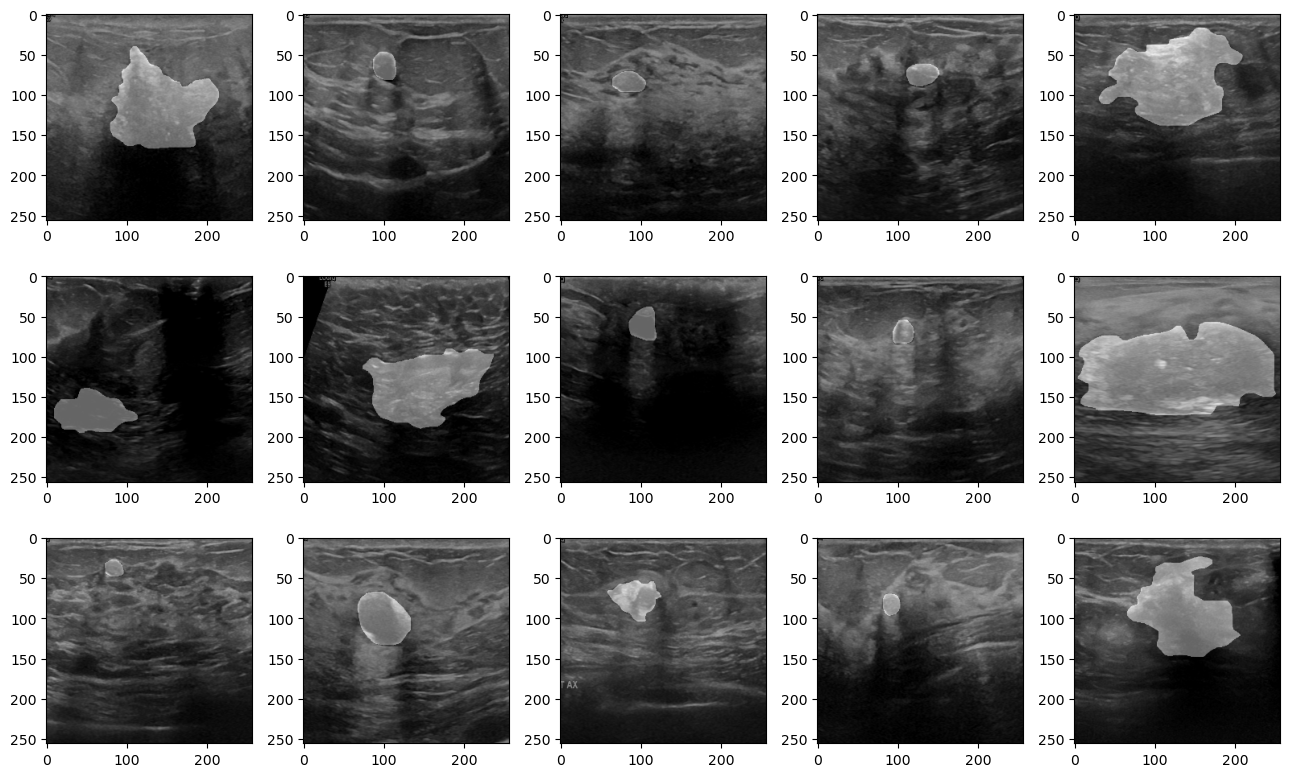

In [9]:
# Function to overlay mask on image for visualization
def show_mask(image, mask, cmap, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)

# Visualize random images and masks
plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    idx = np.random.randint(len(images))    
    show_mask(images[idx], masks[idx], cmap='jet')        
    # show_mask(images[id], masks[id], cmap=plt.get_cmap('binary'))
    # show_mask(images[id], masks[id], cmap='afmhot')
    # show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

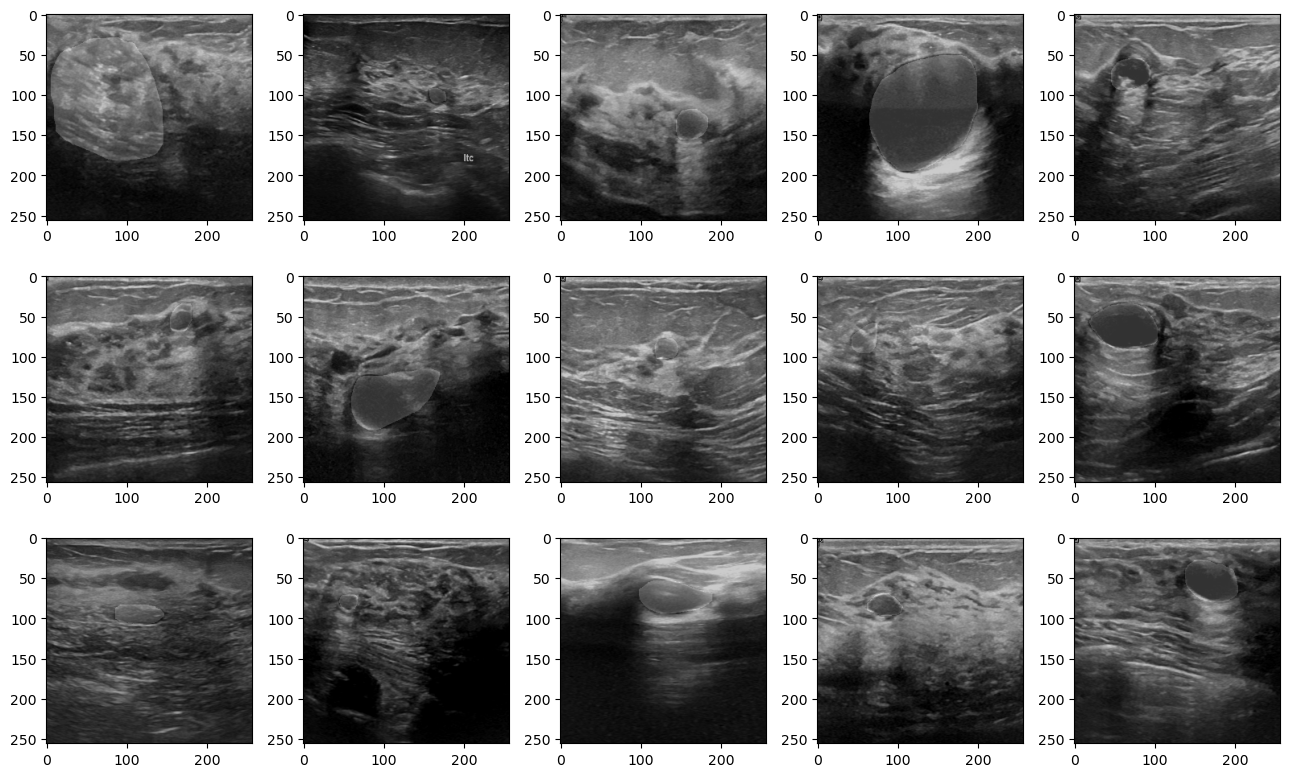

In [76]:
# Function to overlay mask on image for visualization
def show_mask(image, mask, cmap, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)

# Visualize random images and masks
plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    idx = np.random.randint(len(benign_images))    
    show_mask(benign_images[idx], benign_masks[idx], cmap='jet', alpha=0.2)        
    # show_mask(images[id], masks[id], cmap=plt.get_cmap('binary'))
    # show_mask(images[id], masks[id], cmap='afmhot')
    # show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

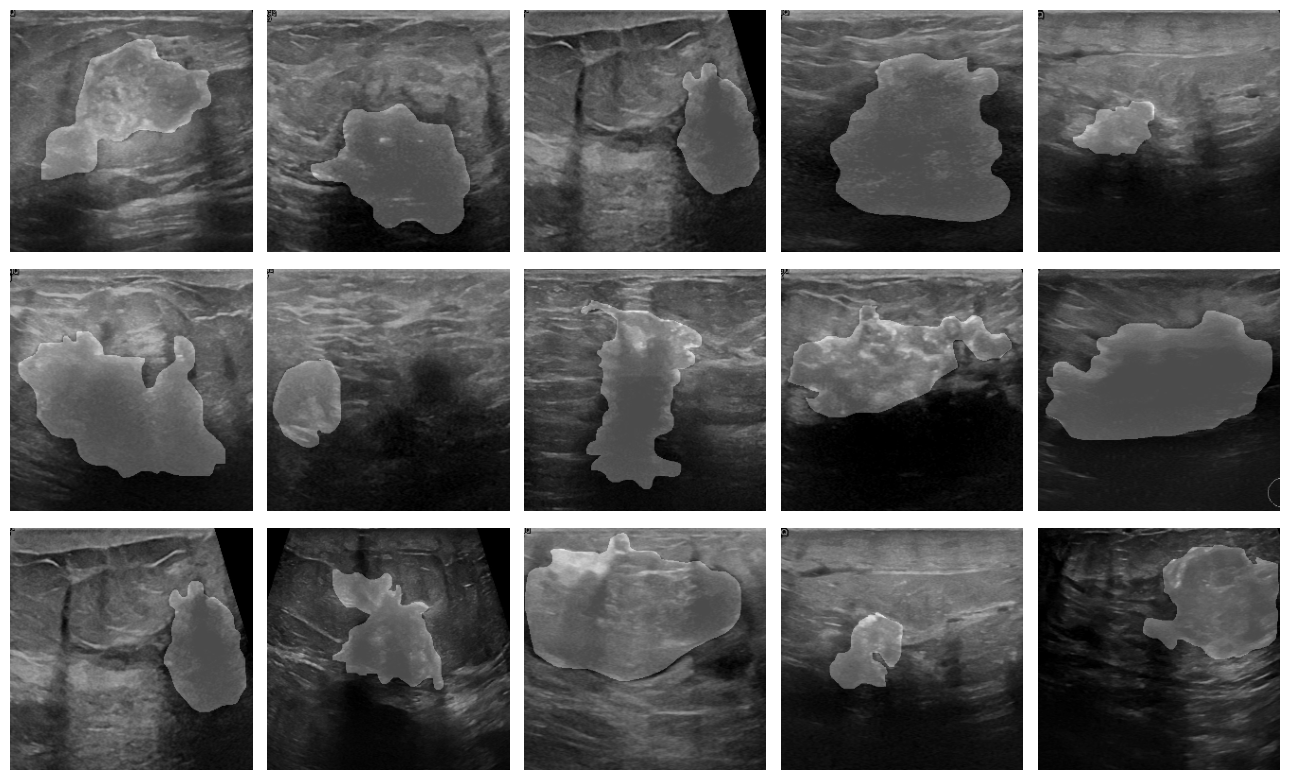

In [81]:
plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    idx = np.random.randint(len(malignant_images))
    show_image(malignant_images[idx])     
    show_mask(malignant_images[idx], malignant_masks[idx], cmap='jet', alpha=0.3)        
    # show_mask(images[id], masks[id], cmap=plt.get_cmap('binary'))
    # show_mask(images[id], masks[id], cmap='afmhot')
    # show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [68]:
def get_labels_from_filenames(image_paths):
    labels = []
    for path in image_paths:
        # Extract class name from the path (modify as needed)
        if "benign" in path.lower():
            labels.append(0)  # Benign -> 0
        elif "malignant" in path.lower():
            labels.append(1)  # Malignant -> 1
        elif "normal" in path.lower():
            labels.append(2)  # Normal -> 2
            raise ValueError(f"Not allowed class in filename: {path}")
        else:
            raise ValueError(f"Unknown class in filename: {path}")
    return labels

In [69]:
all_image_paths = benign_paths + malignant_paths
all_mask_paths = benign_mask_paths + malignant_mask_paths

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    all_image_paths, all_mask_paths, test_size=0.4, random_state=42
)

train_images = load_images(train_image_paths, SIZE)
train_images_greyscale = load_greyscale_images(train_image_paths, SIZE)
train_mask = load_images(train_mask_paths, SIZE)
train_mask_greyscale = load_greyscale_images(train_mask_paths, SIZE)
train_labels = get_labels_from_filenames(image_paths=train_image_paths)



test_images = load_images(test_image_paths, SIZE)
test_images_greyscale = load_greyscale_images(test_image_paths, SIZE)
test_mask = load_images(test_mask_paths, SIZE)
test_mask_greyscale = load_greyscale_images(test_mask_paths, SIZE)
test_labels = get_labels_from_filenames(image_paths=test_image_paths)

# Debug output
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")
print(f"Shape of first train image: {train_images[0].shape}")

Number of train images: 211
Number of test images: 141
Shape of first train image: (256, 256, 3)


In [47]:
# Assert that the classifications are correct
for i, (image_path, label) in enumerate(zip(train_image_paths, train_labels)):
    # Derive the expected classification from the label
    classification = "malignant" if label == 1 else "benign"

    # Perform the element-wise comparison and print the result
    is_correct = ("malignant" in image_path and label == 1) or ("benign" in image_path and label == 0)        
    assert is_correct, f"Incorrect classification at index {i}: {image_path}, Label: {label}"


## Feature extraction / exploration

In [ ]:
import numpy as np
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from scipy.stats import skew, kurtosis

In [ ]:
# Function to extract morphological features from a mask
def extract_morphological_features(mask):
    labeled_img = label(mask)
    regions = regionprops(labeled_img)
    features = {}
    if regions:
        region = regions[0]  # Assume a single region per mask
        features["area_perimeter_ratio"] = region.area / region.perimeter if region.perimeter > 0 else 0
        features["perimeter_area_ratio"] = region.perimeter / region.area if region.area > 0 else 0
        features["eccentricity"] = region.eccentricity
        features["solidity"] = region.solidity
        features["extent"] = region.extent
    else:
        # Handle the case of empty or invalid masks
        features = {
            "area_perimeter_ratio": 0,
            "perimeter_area_ratio": 0,
            "eccentricity": 0,
            "solidity": 0,
            "extent": 0,
        }
    return features

In [ ]:
def extract_texture_features(image, mask):
    if np.any(mask > 0):  # Check if the mask contains non-zero values
        # Apply the mask
        masked_image = image * (mask > 0)
        
        # Convert the masked image to unsigned 8-bit integers
        masked_image = img_as_ubyte(masked_image)
        
        # Compute GLCM
        glcm = graycomatrix(
            masked_image,
            distances=[1],
            angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
            symmetric=True,
            normed=True
        )
        
        # Compute GLCM properties
        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
        }
    else:
        # Handle the case of empty or invalid masks
        features = {
            'contrast': 0,
            'dissimilarity': 0,
            'homogeneity': 0,
            'energy': 0,
            'correlation': 0,
        }
    return features

In [ ]:
def extract_intensity_features(image, mask):
    if np.any(mask > 0):
        masked_image = image * (mask > 0)
        masked_values = masked_image[mask > 0]
        features = {
            "mean_intensity": np.mean(masked_values),
            "std_intensity": np.std(masked_values),
            "min_intensity": np.min(masked_values),
            "max_intensity": np.max(masked_values),
            "skewness": skew(masked_values),
#            "kurtosis": kurtosis(masked_values),
        }
    else:
        features = {
            "mean_intensity": 0,
            "std_intensity": 0,
            "min_intensity": 0,
            "max_intensity": 0,
            "skewness": 0,
#            "kurtosis": 0,
        }
    return features

In [48]:



# Function to extract all features
def extract_features(image, mask):
    morphological_features = extract_morphological_features(mask)
    intensity_features = extract_intensity_features(image, mask)
    texture_features = extract_texture_features(image, mask)
    all_features = {**morphological_features, **intensity_features, **texture_features}
    return all_features

# With Masks

In [56]:
# Extract features for training and mask_pathtesting
train_features_with_masks = [extract_features(img, mask) for img, mask in zip(train_images_greyscale, train_mask_greyscale)]
test_features_with_masks = [extract_features(img, mask) for img, mask in zip(test_images_greyscale, test_mask_greyscale)]

train_df_with_labels = pd.DataFrame(train_features_with_masks)
train_df_with_labels['label'] = train_labels 

# Convert feature dictionaries to DataFrame
train_df_with_masks = pd.DataFrame(train_features_with_masks)
test_df_with_masks = pd.DataFrame(test_features_with_masks)

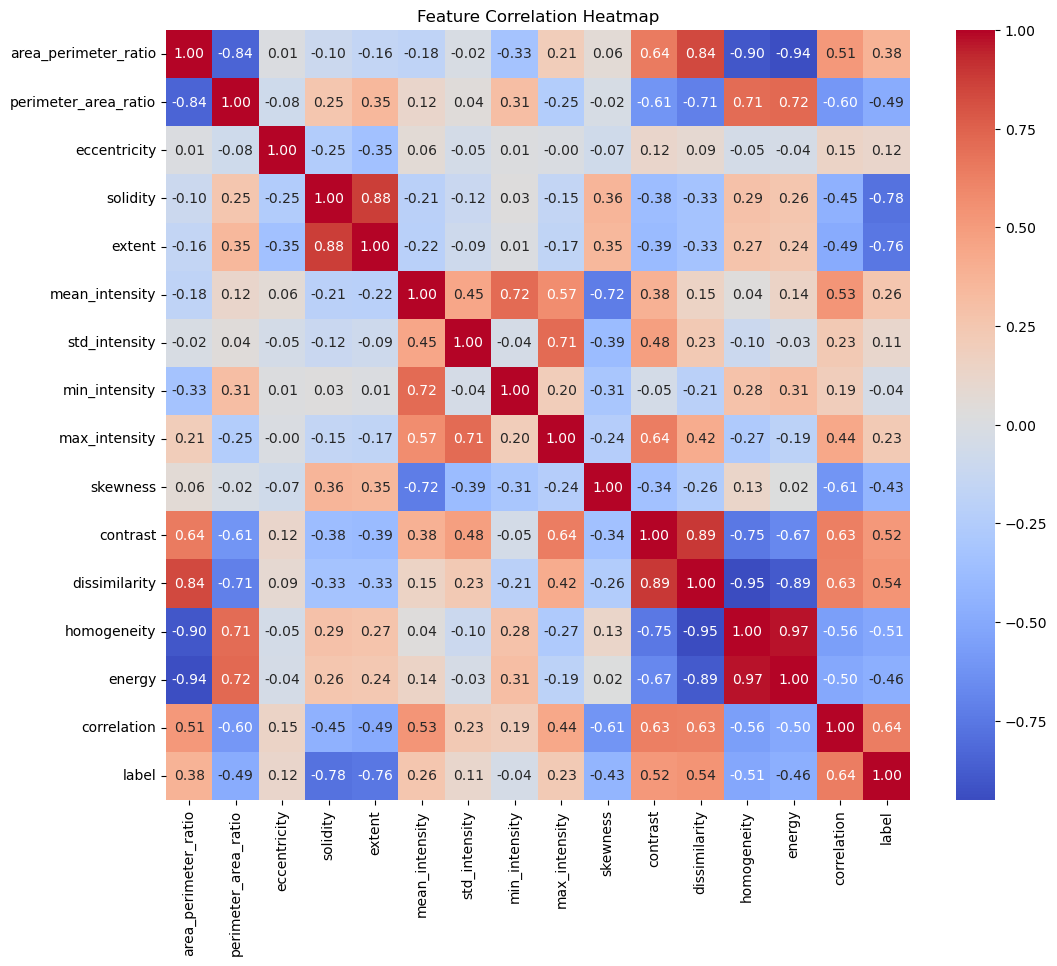

In [50]:
# Compute correlation matrix
correlation_matrix_with_masks = train_df_with_labels.corr()

# Plot heatmap8
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_masks, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [57]:
# Identify highly correlated features (threshold = 0.9)
correlation_threshold = 0.9
correlated_features = set()

for i in range(len(correlation_matrix_with_masks.columns)):
    for j in range(i):
        if abs(correlation_matrix_with_masks.iloc[i, j]) > correlation_threshold:
            feature_name = correlation_matrix_with_masks.columns[i]
            correlated_features.add(feature_name)

print("Highly correlated features to remove:", correlated_features)

# Drop correlated features from the dataset
train_df_with_masks = train_df_with_masks.drop(columns=correlated_features)
test_df_with_masks = test_df_with_masks.drop(columns=correlated_features)

Highly correlated features to remove: {'homogeneity', 'energy'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest Model Training
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_leaf=2, min_samples_split=10, max_depth=10)

# Fit the model
rf_model.fit(train_df_with_masks, train_labels)

# Predictions on test set
test_predictions_with_masks = rf_model.predict(test_df_with_masks)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_labels, test_predictions_with_masks))
print("Accuracy Score:", accuracy_score(test_labels, test_predictions_with_masks))

print(test_features_with_masks)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.97      0.99      0.98        70

    accuracy                           0.98       141
   macro avg       0.98      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141

Accuracy Score: 0.9787234042553191
[{'area_perimeter_ratio': 18.172944334904106, 'perimeter_area_ratio': 0.05502685649453825, 'eccentricity': 0.5174971061087492, 'solidity': 0.8082216425294594, 'extent': 0.5999599358974359, 'mean_intensity': 0.16515745459991013, 'std_intensity': 0.11915609622689327, 'min_intensity': 0.0, 'max_intensity': 0.7889000773429871, 'skewness': 1.1061950650358394, 'contrast': 51.90646295896006, 'dissimilarity': 1.3537990196078933, 'homogeneity': 0.8780637076645154, 'energy': 0.8559195284563815, 'correlation': 0.9249590786596111}, {'area_perimeter_ratio': 27.659616219045954, 'perimeter_area_ratio': 0.0361537915812229, 

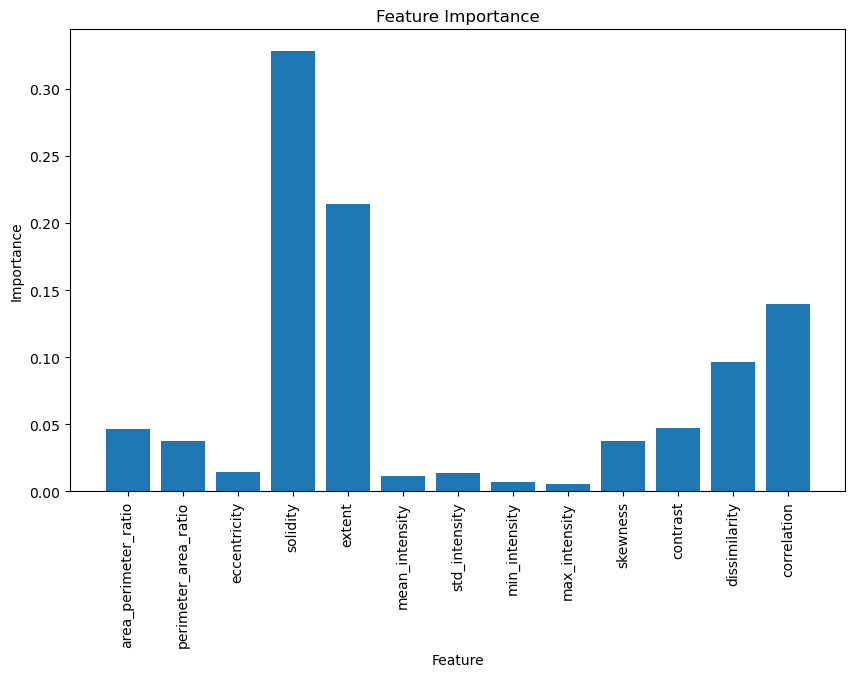

In [59]:
# Get feature importance from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.bar(train_df_with_masks.columns, feature_importances)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(train_df_with_masks, train_labels)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.97      0.99      0.98        70

    accuracy                           0.98       141
   macro avg       0.98      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Accuracy Score: 0.9787234042553191
[{'area_perimeter_ratio': 18.172944334904106, 'perimeter_area_ratio': 0.05502685649453825, 'eccentricity': 0.5174971061087492, 'solidity': 0.8082216425294594, 'extent': 0.5999599358974359, 'm

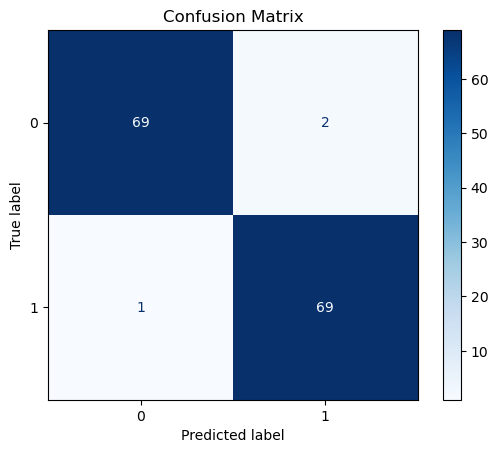

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest Model Training
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_leaf=2, min_samples_split=5, max_depth=None)

# Fit the model
rf_model.fit(train_df_with_masks, train_labels)

# Predictions on test set
test_predictions = rf_model.predict(test_df_with_masks)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_labels, test_predictions))
print(test_labels)
print("Accuracy Score:", accuracy_score(test_labels, test_predictions))
print(test_features_with_masks)

cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Withouth Masks

In [82]:
def extract_morphological_features_no_mask(image):
    labeled_img = label(image > 0)  # Use non-zero pixels as regions
    regions = regionprops(labeled_img)
    features = {}
    if regions:
        region = regions[0]  # Assume a single region for simplicity
        features["area_perimeter_ratio"] = region.area / region.perimeter if region.perimeter > 0 else 0
        features["perimeter_area_ratio"] = region.perimeter / region.area if region.area > 0 else 0
        features["eccentricity"] = region.eccentricity
        features["solidity"] = region.solidity
        features["extent"] = region.extent
    else:
        # Handle the case of empty or invalid regions
        features = {
            "area_perimeter_ratio": 0,
            "perimeter_area_ratio": 0,
            "eccentricity": 0,
            "solidity": 0,
            "extent": 0,
        }
    return features

In [83]:
def extract_texture_features_no_mask(image):
    # Convert the image to unsigned 8-bit integers
    image_ubyte = img_as_ubyte(image)
    
    # Compute GLCM
    glcm = graycomatrix(
        image_ubyte,
        distances=[1],
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
        symmetric=True,
        normed=True
    )
    
    # Compute GLCM properties
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
    }
    return features


In [84]:
from scipy.stats import skew, kurtosis

def extract_intensity_features_no_mask(image):
    pixel_values = image[image > 0]  # Use only non-zero pixels to avoid background effects
    features = {
        "mean_intensity": np.mean(pixel_values),
        "std_intensity": np.std(pixel_values),
        "min_intensity": np.min(pixel_values),
        "max_intensity": np.max(pixel_values),
        "skewness": skew(pixel_values),
    }
    return features

In [85]:
def extract_features_no_mask(image):
    morphological_features = extract_morphological_features_no_mask(image)
    intensity_features = extract_intensity_features_no_mask(image)
    texture_features = extract_texture_features_no_mask(image)
    all_features = {**morphological_features, **intensity_features, **texture_features}
    return all_features

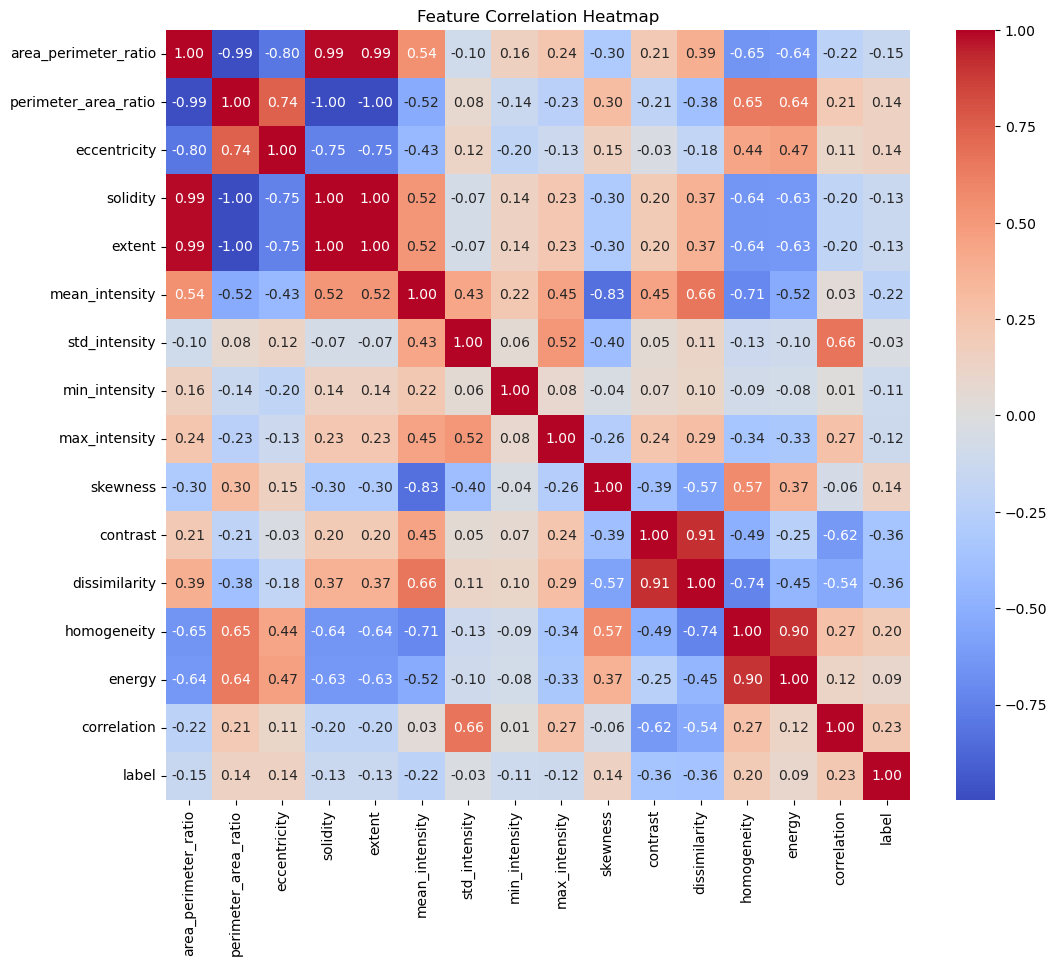

Highly correlated features to remove: {'dissimilarity', 'perimeter_area_ratio', 'solidity', 'extent'}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70        71
           1       0.69      0.77      0.73        70

    accuracy                           0.72       141
   macro avg       0.72      0.72      0.72       141
weighted avg       0.72      0.72      0.72       141

Accuracy Score: 0.7163120567375887
[{'area_perimeter_ratio': 61.42955038396567, 'perimeter_area_ratio': 0.01627881034045497, 'eccentricity': 0.0020621005992834634, 'solidity': 0.9998321533203125, 'extent': 0.9998321533203125, 'mean_intensity': 0.30254300034251125, 'std_intensity': 0.2054702468634288, 'min_intensity': 9.999999747378752e-05, 'max_intensity': 0.8809000849723816, 'skewness': 0.4832631985382274, 'contrast': 109.52709991349914, 'dissimilarity': 7.305213109140747, 'homogeneity': 0.14683057080356948, 'energy': 0.01719902541639218, 'c

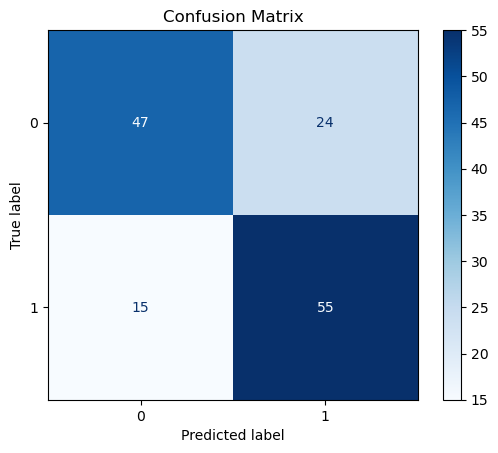

In [86]:
# Extract features for training and mask_pathtesting
train_features = [extract_features_no_mask(img) for img in train_images_greyscale]
test_features = [extract_features_no_mask(img) for img in test_images_greyscale]

train_df_with_labels = pd.DataFrame(train_features)
train_df_with_labels['label'] = train_labels 

# Convert feature dictionaries to DataFrame
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

# Compute correlation matrix
correlation_matrix = train_df_with_labels.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Identify highly correlated features (threshold = 0.9)
correlation_threshold = 0.9
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_name = correlation_matrix.columns[i]
            correlated_features.add(feature_name)

print("Highly correlated features to remove:", correlated_features)

# Drop correlated features from the dataset
train_df = train_df.drop(columns=correlated_features)
test_df = test_df.drop(columns=correlated_features)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest Model Training
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_leaf=2, min_samples_split=10, max_depth=10)
rf_model.fit(train_df, train_labels)
test_predictions = rf_model.predict(test_df)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_labels, test_predictions))
print("Accuracy Score:", accuracy_score(test_labels, test_predictions))

print(test_features)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest Model Training
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_leaf=2, min_samples_split=5, max_depth=None)

# Fit the model
rf_model.fit(train_df, train_labels)

# Predictions on test set
test_predictions = rf_model.predict(test_df)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_labels, test_predictions))
print(test_labels)
print("Accuracy Score:", accuracy_score(test_labels, test_predictions))
print(test_features)

cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions
pca = PCA(n_components=10)
train_pca = pca.fit_transform(train_df)
test_pca = pca.transform(test_df)

# Train the Random Forest on reduced data
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_pca.fit(train_pca, train_labels)

# Predictions and evaluation
test_predictions_pca = rf_model_pca.predict(test_pca)
print("Accuracy after PCA:", accuracy_score(test_labels, test_predictions_pca))

In [ ]:
import re
def extract_number_from_filename(filepath):
    # Extract number inside parentheses using regex
    match = re.search(r'\((\d+)\)', filepath)
    return int(match.group(1)) if match else None

# Compare lists
def compare_image_and_mask_paths(image_paths, mask_paths):
    results = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img_num = extract_number_from_filename(img_path)
        mask_num = extract_number_from_filename(mask_path)
        match = img_num == mask_num
        results.append({
            "image_path": img_path,
            "mask_path": mask_path,
            "match": match
        })
    return results

# Run the comparison
comparison_results = compare_image_and_mask_paths(image_paths, mask_paths)

# Display results
for result in comparison_results:
    if(result['match']):
        print(f"Image: {result['image_path']}, Mask: {result['mask_path']}, Match: {result['match']}")

In [18]:
    # Function to extract morphological features using relative values
#    def extract_morphological_features(mask):
#        labeled_img = label(mask)
#        regions = regionprops(labeled_img)
#        features = {}
#        if regions:
#            region = regions[0]  # Assume a single region per mask
#            features["area_perimeter_ratio"] = region.area / region.perimeter
#            features["perimeter_area_ratio"] = region.perimeter / region.area
#            features["eccentricity"] = region.eccentricity
#            features["solidity"] = region.solidity
#            features["extent"] = region.extent
#        return features

In [ ]:

#features["area_perimeter_ratio"] = region.area / region.perimeter
#features["perimeter_area_ratio"] = region.perimeter / region.area
#features["eccentricity"] = region.eccentricity
#features["solidity"] = region.solidity
#features["extent"] = region.extent
#
#'contrast': graycoprops(glcm, 'contrast').mean(),
#            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
#            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
#            'energy': graycoprops(glcm, 'energy').mean(),
#            'correlation': graycoprops(glcm, 'correlation').mean()
#"mean_intensity": np.mean(masked_image),
#            "std_intensity": np.std(masked_image),
#            "min_intensity": np.min(masked_image),
#            "max_intensity": np.max(masked_image)